# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = "traffic-signs-data/train.p"
testing_file = "traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.

coord_train = train['coords']
coord_test = test['coords']

print(coord_test)

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

[[ 6  5 48 49]
 [ 5  5 36 40]
 [ 6  6 43 47]
 ..., 
 [ 6  6 24 24]
 [ 5  6 43 44]
 [ 6  5 27 26]]
Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

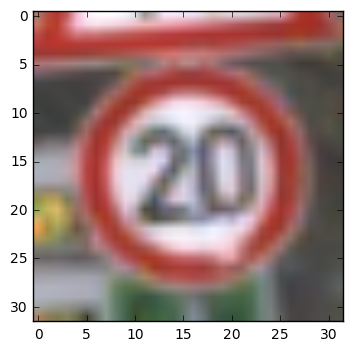

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

from sklearn.utils import shuffle
plt.imshow(X_train[12])



----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

im1 (32, 32, 1)
im2 (32, 32)
im3 (32, 32, 1)


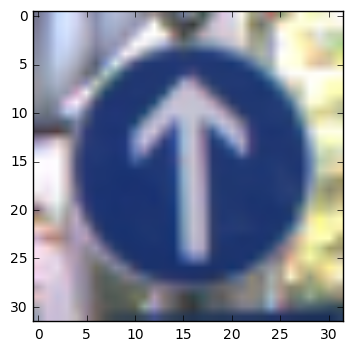

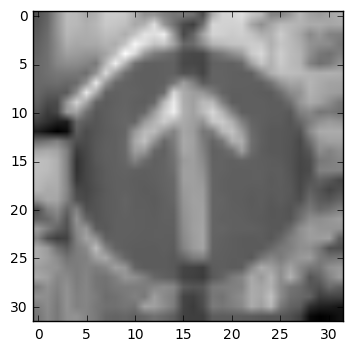

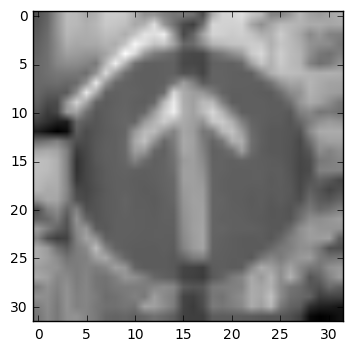

In [43]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

from sklearn.utils import shuffle
from collections import defaultdict
import cv2
import numpy as np
import tensorflow as tf
import random

def transform_color(X, coord):
    colored = []
    for im, c in zip(X, coord):
        im = cv2.cvtColor(im, cv2.COLOR_RGB2YUV)
        gray = im[:,:,0:1]
        gray = gray - np.mean(gray, axis=0)
        gray = gray / (np.std(gray, axis=0) + 1e-10)
        colored.append(gray)
    return np.array(colored)

def transform_image(im, theta, x, y, ratio):
    r, c, _ = im.shape
    center = (c//2, r//2)
    rotM = cv2.getRotationMatrix2D(center, theta, 1.)
    transM = np.float32([[1,0,x],[0,1,y]])
    im = cv2.warpAffine(im, rotM, (c,r))
    im = cv2.warpAffine(im, transM, (c,r))
    im = im.reshape(list(im.shape) + [1])
    return im
    

def balance(X, y, coord):
    ycnt = {i: np.count_nonzero(y == i) for i in set(y)}
    ymax = 2 * max(ycnt.values())
    yadj = {v: ymax//c for v, c in ycnt.items()}
    Xplus = []
    yplus = []
    coordplus = []
    for xx, yy, cc in zip(X, y, coord):
        for i in range(yadj[yy]):
            tx = int(random.random() * 4) - 2
            ty = int(random.random() * 4) - 2
            theta = int(random.random() * 20) - 10
            ratio = random.random() * 0.2 + 0.9
            trans_xx = transform_image(xx, theta, tx, ty, ratio)
            Xplus.append(trans_xx)
            yplus.append(yy)
            coordplus.append(cc)
    return Xplus, yplus, coordplus

colored_X = transform_color(X_train, coord_train)

i = 34343
plt.imshow(X_train[i])
plt.figure()
plt.imshow(colored_X[i].squeeze(), cmap='gray')
transformed_X = transform_image(colored_X[i], 10, 0, 0, 0.)
plt.figure()
plt.imshow(transformed_X.squeeze(), cmap='gray')


X_test_colored = transform_color(X_test, coord_test)
balanced_X, balanced_y, balanced_coord = balance(colored_X, y_train, coord_train)

X_proc, y_proc, coord_proc = shuffle(balanced_X, balanced_y, balanced_coord)



### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

- I transformed the images to the YUV colorspace to help the network correlate color information easily. After many experiments, I decided to retain only the Y channel since that gave better performance than with the color channels



In [44]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

X_input, X_valid, y_input, y_valid = train_test_split(X_proc, y_proc, test_size = 0.20)
print(len(X_input), len(X_valid))

66405 16602


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

- The data was unbalanced and did not equally represent the various output channels. So, I replicated the samples for the under-represented samples. This is important because the training of the network will turn out to be biased if one channel has too many representative samples. It might even turn out that all samples of a particular channel are selected out of the training data and that'll result in poor validation accuracy.

In [45]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

mu = 0.0
sigma = 0.1

learning_rate = 0.001
batch_size = 128
epochs = 100
dropout = 1.

weights = {
    "layer1": tf.Variable(tf.truncated_normal([5, 5, 1, 6], mu, sigma)),
    "layer2": tf.Variable(tf.truncated_normal([5, 5, 6, 16], mu, sigma)),
    "layer3": tf.Variable(tf.truncated_normal([14*14*6 + 5*5*16, 120], mu, sigma)),
    "layer4": tf.Variable(tf.truncated_normal([120, 84], mu, sigma)),
    "out": tf.Variable(tf.truncated_normal([84, n_classes], mu, sigma))  
}

bias = {
    "layer1": tf.Variable(tf.truncated_normal([6], mu, sigma)),
    "layer2": tf.Variable(tf.truncated_normal([16], mu, sigma)),
    "layer3": tf.Variable(tf.truncated_normal([120], mu, sigma)),
    "layer4": tf.Variable(tf.truncated_normal([84], mu, sigma)),
    "out": tf.Variable(tf.truncated_normal([n_classes], mu, sigma))       
}

# bias = {
#     "layer1": tf.Variable(tf.zeros([6])),
#     "layer2": tf.Variable(tf.zeros([16])),
#     "layer3": tf.Variable(tf.zeros([120])),
#     "layer4": tf.Variable(tf.zeros([84])),
#     "out": tf.Variable(tf.zeros([n_classes]))       
# }


def lenet(input, weights, bias, keep_prob):
    layer1 = tf.nn.conv2d(input, weights['layer1'], [1, 1, 1, 1], "VALID") + bias['layer1']
    layer1 = tf.nn.relu(layer1)
    layer1 = tf.nn.max_pool(layer1, [1, 2, 2, 1], [1, 2, 2, 1], "VALID")
    
    layer1 = tf.nn.dropout(layer1, keep_prob)
        
    layer2 = tf.nn.conv2d(layer1, weights['layer2'], [1, 1, 1, 1], "VALID") + bias['layer2']
    layer2 = tf.nn.relu(layer2)
    layer2 = tf.nn.max_pool(layer2, [1, 2, 2, 1], [1, 2, 2, 1], "VALID")
    
    layer2 = tf.nn.dropout(layer2, keep_prob)
    
    layer1_output = tf.reshape(layer1, [-1, 14*14*6])
    layer2_output = tf.reshape(layer2, [-1, 5*5*16])
    layer3_input = tf.concat(1, [layer1_output, layer2_output])
    
    layer3 = tf.matmul(layer3_input, weights['layer3']) + bias['layer3']
    layer3 = tf.nn.relu(layer3)
    
    layer4 = tf.matmul(layer3, weights['layer4']) + bias['layer4']
    layer4 = tf.nn.relu(layer4)
    
    out = tf.matmul(layer4, weights['out']) + bias['out']
    return out


X = tf.placeholder(tf.float32, [None, 32, 32, 1])
y = tf.placeholder(tf.int32, [None])
one_hot_y = tf.one_hot(y, n_classes)
keep_prob = tf.placeholder(tf.float32)


logits = lenet(X, weights, bias, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_operation = optimizer.minimize(loss_operation)

prediction = tf.argmax(logits, 1)
correct_prediction = tf.equal(prediction, tf.argmax(one_hot_y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for b in range(0, num_examples, batch_size):
        end = b + batch_size
        X_batch, y_batch = X_data[b:end], y_data[b:end]
        acc = sess.run(accuracy, feed_dict = {X: X_batch, y: y_batch, keep_prob: 1.})
        total_accuracy += acc * len(X_batch)
    return total_accuracy / num_examples

saver = tf.train.Saver()



### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:** My model has four layers, two convolutional and two fully-connected. 

Each of the convolutional layers are followed by an activation and maxpooling layer. These two layers contribute in translation-invariant feature-extraction. 

These features are then fed into a classifier consisting to two fully-connected layers.

In [46]:
### Train your model here.
### Feel free to use as many code cells as needed.
from datetime import datetime

n_input = len(X_input)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        X_input, y_input = shuffle(X_input, y_input)
        for b in range(0, n_input, batch_size):
            end = b + batch_size
            batch_x, batch_y = X_input[b:end], y_input[b:end]
            sess.run(training_operation, feed_dict = {X: batch_x, y: batch_y, keep_prob: dropout})
        validation_accuracy = evaluate(X_valid, y_valid)
        validation_cost = sess.run(loss_operation, feed_dict={X: X_valid, y: y_valid, keep_prob: 1.})
        print("At epoch ", e+1, " validation accuracy = ", validation_accuracy, " cost = ",validation_cost, " @ ", str(datetime.now()))

    
    
    pred = sess.run(prediction, feed_dict = {X: X_valid, keep_prob: 1.})
    wrong_X = np.array(X_valid)[pred != y_valid]
    wrong_y = np.array(pred)[pred!=y_valid]
    correct_y = np.array(y_valid)[pred!=y_valid]    
    for wx, wy, wyy  in zip(wrong_X[:5], wrong_y[:5], correct_y[:5]):
        #plt.imshow(cv2.cvtColor(wx,cv2.COLOR_HSV2RGB))
        plt.imshow(wx.squeeze(), cmap='gray')
        plt.figure()
        print(wy, wyy)
        
    test_accuracy = evaluate(X_test_colored, y_test)
    print('test-accuracy ', test_accuracy)
    
    #saver.save(sess, "traffic-new-model")
        


At epoch  1  validation accuracy =  0.955246355717  cost =  0.150253  @  2017-01-24 19:17:28.781089
At epoch  2  validation accuracy =  0.971810625082  cost =  0.0881419  @  2017-01-24 19:18:03.478927
At epoch  3  validation accuracy =  0.975966750836  cost =  0.0735328  @  2017-01-24 19:18:38.254158
At epoch  4  validation accuracy =  0.98421876883  cost =  0.0534197  @  2017-01-24 19:19:13.530769
At epoch  5  validation accuracy =  0.986146247454  cost =  0.049145  @  2017-01-24 19:19:48.392563
At epoch  6  validation accuracy =  0.983556198063  cost =  0.0566274  @  2017-01-24 19:20:22.835336
At epoch  7  validation accuracy =  0.991808215727  cost =  0.0307802  @  2017-01-24 19:20:57.303260
At epoch  8  validation accuracy =  0.974159739654  cost =  0.111108  @  2017-01-24 19:21:31.735557
At epoch  9  validation accuracy =  0.990483074336  cost =  0.0346553  @  2017-01-24 19:22:06.544745
At epoch  10  validation accuracy =  0.989398867621  cost =  0.0385365  @  2017-01-24 19:22:41.

KeyboardInterrupt: 

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_

I used the Adam optimizer with a learning-rate of `0.001` and a batch-size of `128`. An epoch of `200` to `300` runs seems to stabilize the parameters.


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:** 

I started out with the basic LeNet architecture and took one step at a time as I saw validation accuracy improve:

1. Convert to YUV. Get rid of colour channels
2. Feed back the first convolution layer's output as well to the classifier. This might have helped by retaining low level features that are useful for classification
3. Attempted to draw attention to bounding-box by increasing brightness around the space. This didn't seem to help


---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [8]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [9]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [10]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.